In [4]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [5]:
all_data = loadmat('data/sample_1.mat')
keys = all_data.keys()
keys

dict_keys(['__header__', '__version__', '__globals__', 'samplingInterval', 'startData', 'chan', 'data', 'spike_times', 'spike_class'])

In [6]:
sample_data= all_data["data"]
sample_data.shape

(1, 2880000)

In [8]:
# Sampling rate of 32.051 kHz (32051 samples per second )
length_recording_sec = len(sample_data[0])/32051
length_recording_sec

89.85679073975851

In [9]:
# First look at the data
sample_data[0][:10]

array([  4.72638058,   4.26466759,   0.88346865,  -4.50652145,
        -6.56673384,  -4.74522643,  -4.88467592,  -7.50170421,
        -9.06807008, -10.42088687])

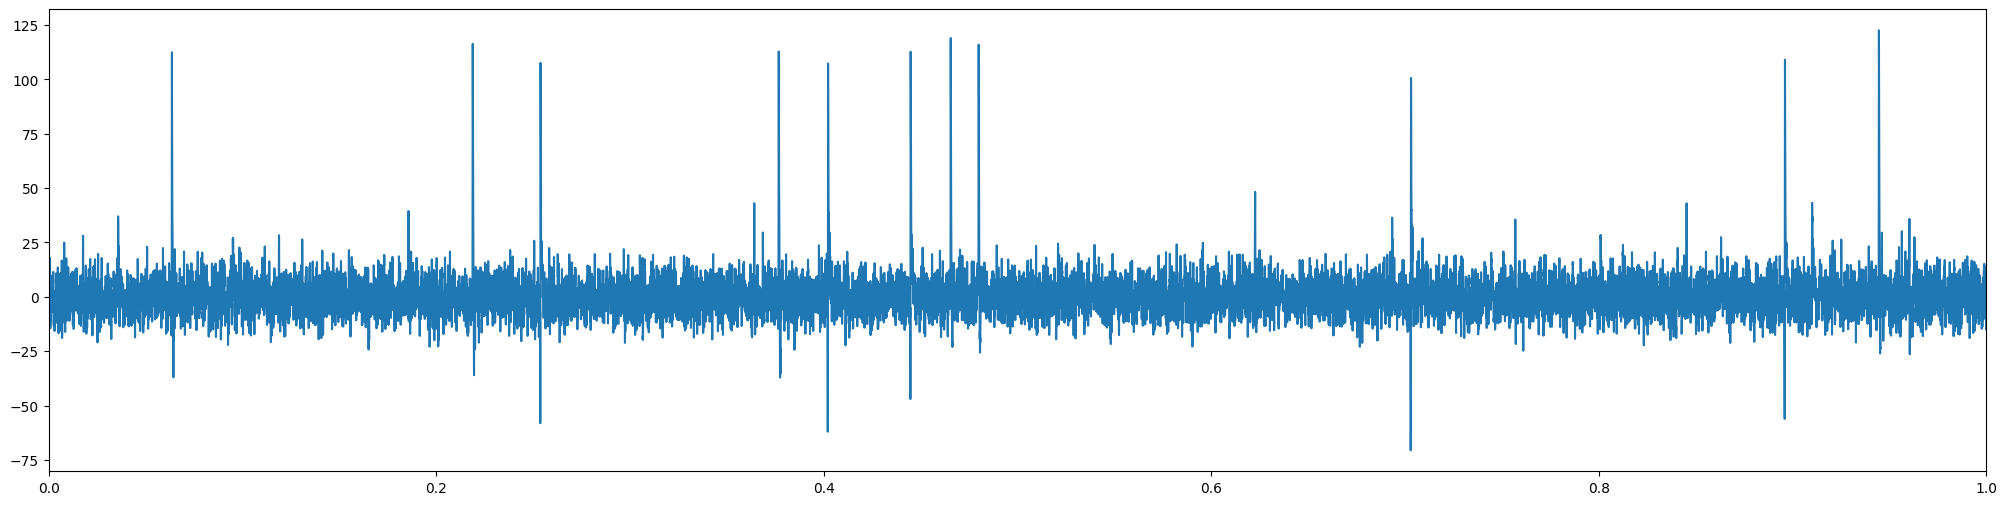

In [10]:
# Plot the data
seconds = 1
sr = 32051

data = sample_data[0][:round(seconds*sr)]
plt.figure(figsize=(25,6))
plt.plot(np.linspace(0, seconds, round(seconds*sr)), data)
plt.xlim(0, seconds)

plt.show()

In [11]:
# Filter Data by subtracting average
average_spike_value = np.sum(sample_data[0])/len(sample_data[0])
average_spike_value
# Does not seem  to make sense

np.float64(0.4507385876702088)

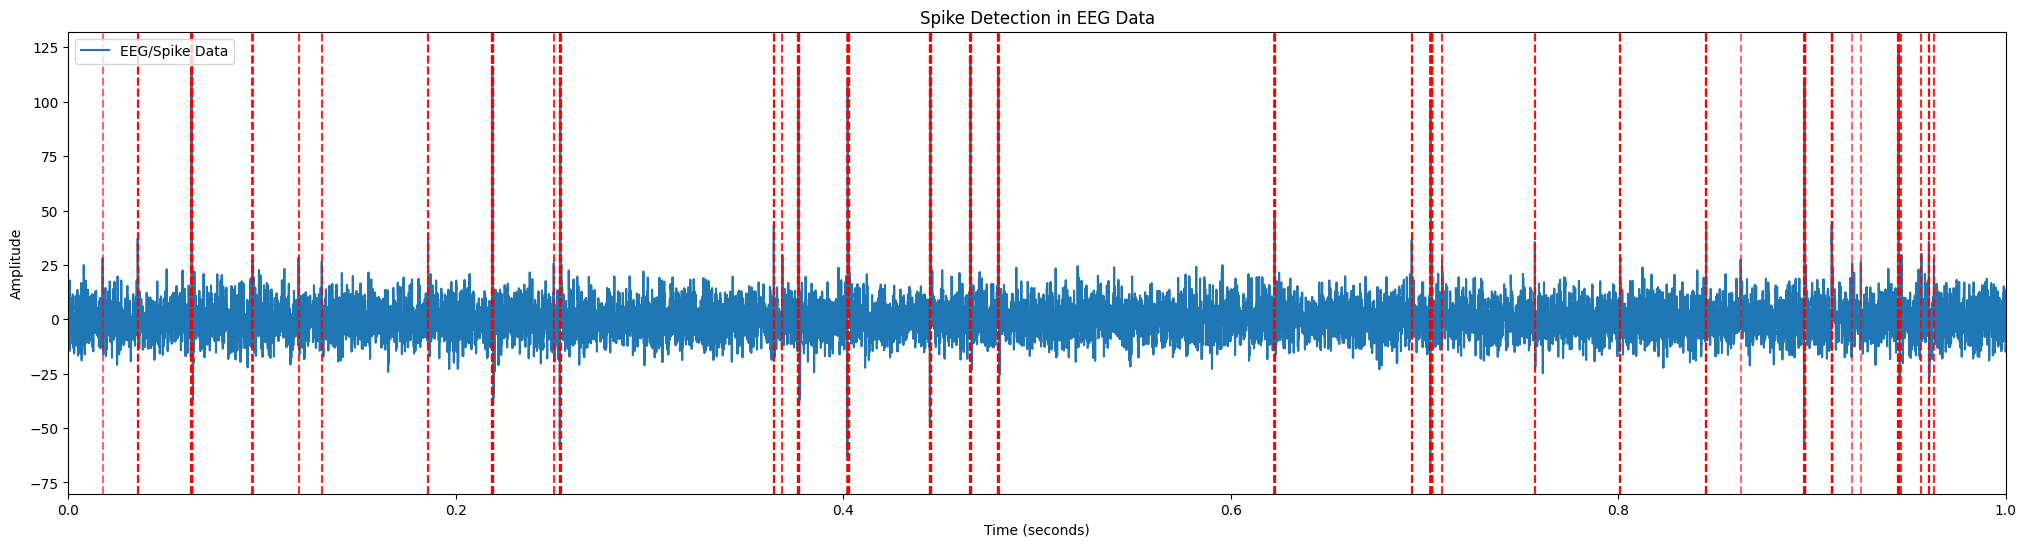

In [19]:
# Define the threshold for spike detection
threshold = 25

# Plot the raw data
plt.figure(figsize=(25, 6))
time = np.linspace(0, seconds, round(seconds * sr))
plt.plot(time, data, label='EEG/Spike Data')
plt.xlim(0, seconds)

# Detect spikes (where data exceeds the threshold)
spike_times_indices = np.where(data > threshold)[0]  # Find the indices where data exceeds threshold

# Convert spike indices to time in seconds
spike_times_seconds = spike_times_indices / sr



# Mark detected spikes with vertical lines
for spike_time in spike_times_seconds:
    plt.axvline(spike_time, color='r', linestyle='--', alpha=0.6, label='Detected Spikes' if spike == spike_times[0] else "")

# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Spike Detection in EEG Data')
plt.legend()

plt.show()

In [20]:
# Extract the corresponding data values for the detected spikes
spike_values = data[spike_times_indices]
# Combine spike indices and their corresponding data values into a single matrix
spike_matrix = np.column_stack((spike_times_indices, spike_values))

# Output the combined spike matrix
print("Combined Spike Matrix (Index, Value):")
print(spike_matrix)

Combined Spike Matrix (Index, Value):
[[5.66000000e+02 2.80615822e+01]
 [1.14500000e+03 2.99522291e+01]
 [1.14600000e+03 3.70132609e+01]
 [1.14700000e+03 3.53849343e+01]
 [1.14800000e+03 2.90189890e+01]
 [2.03400000e+03 5.05615801e+01]
 [2.03500000e+03 9.29034473e+01]
 [2.03600000e+03 1.12431961e+02]
 [2.03700000e+03 1.02215563e+02]
 [2.03800000e+03 8.31293232e+01]
 [2.03900000e+03 7.08328920e+01]
 [2.04000000e+03 5.90061360e+01]
 [2.04100000e+03 4.74865911e+01]
 [2.04200000e+03 3.87106355e+01]
 [2.04300000e+03 3.61104069e+01]
 [2.04400000e+03 3.53587273e+01]
 [2.04500000e+03 3.28409705e+01]
 [2.04600000e+03 3.20019854e+01]
 [2.04700000e+03 3.22085351e+01]
 [2.04800000e+03 2.77378259e+01]
 [3.04300000e+03 2.64834892e+01]
 [3.04400000e+03 2.69545769e+01]
 [3.04700000e+03 2.66897189e+01]
 [3.04800000e+03 2.69081250e+01]
 [3.80700000e+03 2.83319233e+01]
 [3.80800000e+03 2.79282864e+01]
 [4.19100000e+03 2.64172391e+01]
 [4.19200000e+03 2.51350015e+01]
 [5.94900000e+03 2.77473400e+01]
 [5.9

Combined Spike Matrix with Cluster Labels (Index, Value, Cluster):
[[5.66000000e+02 2.80615822e+01 0.00000000e+00]
 [1.14500000e+03 2.99522291e+01 0.00000000e+00]
 [1.14600000e+03 3.70132609e+01 0.00000000e+00]
 [1.14700000e+03 3.53849343e+01 0.00000000e+00]
 [1.14800000e+03 2.90189890e+01 0.00000000e+00]
 [2.03400000e+03 5.05615801e+01 2.00000000e+00]
 [2.03500000e+03 9.29034473e+01 1.00000000e+00]
 [2.03600000e+03 1.12431961e+02 1.00000000e+00]
 [2.03700000e+03 1.02215563e+02 1.00000000e+00]
 [2.03800000e+03 8.31293232e+01 1.00000000e+00]
 [2.03900000e+03 7.08328920e+01 2.00000000e+00]
 [2.04000000e+03 5.90061360e+01 2.00000000e+00]
 [2.04100000e+03 4.74865911e+01 2.00000000e+00]
 [2.04200000e+03 3.87106355e+01 0.00000000e+00]
 [2.04300000e+03 3.61104069e+01 0.00000000e+00]
 [2.04400000e+03 3.53587273e+01 0.00000000e+00]
 [2.04500000e+03 3.28409705e+01 0.00000000e+00]
 [2.04600000e+03 3.20019854e+01 0.00000000e+00]
 [2.04700000e+03 3.22085351e+01 0.00000000e+00]
 [2.04800000e+03 2.77

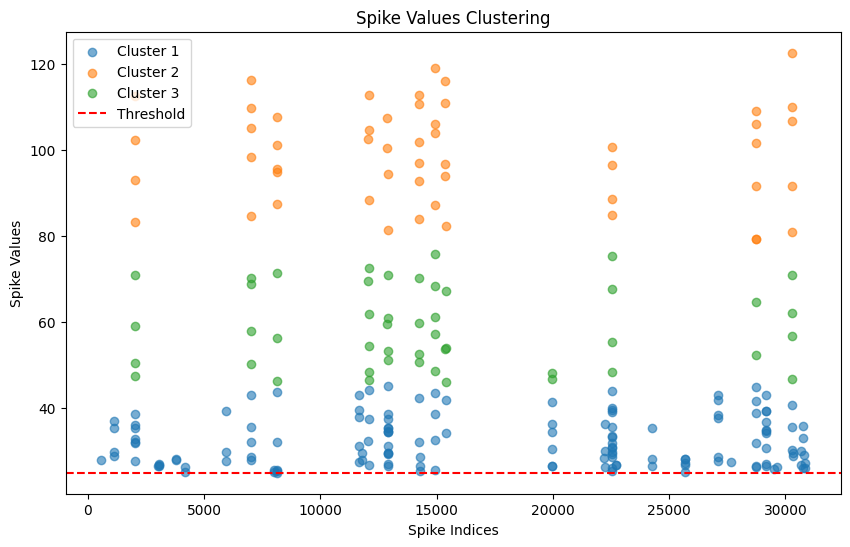

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Applying K-Means Clustering
n_clusters = 3  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# Use only the values for clustering
kmeans.fit(spike_matrix[:, 1].reshape(-1, 1))  # Clustering based on spike values

# Get cluster labels
spike_labels = kmeans.labels_

# Combine the original spike_matrix with the cluster labels
spike_with_labels = np.column_stack((spike_matrix, spike_labels))

# Output the combined spike matrix with labels
print("Combined Spike Matrix with Cluster Labels (Index, Value, Cluster):")
print(spike_with_labels)

# Optional: Plot the spikes colored by their cluster
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.scatter(spike_matrix[spike_labels == i][:, 0], spike_matrix[spike_labels == i][:, 1],
                label=f'Cluster {i+1}', alpha=0.6)

plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Spike Values Clustering")
plt.xlabel("Spike Indices")
plt.ylabel("Spike Values")
plt.legend()
plt.show()